In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
import xgboost as xgb
import seaborn as sns
import matplotlib

file_path = '/content/musicData.csv'
music_data = pd.read_csv(file_path)
data=pd.read_csv(file_path)
music_data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [ ]:
music_data = data[~data.isna().any(axis=1)].reset_index(drop=True)

In [ ]:
print("{} songs don't have tempo".format(sum(data['tempo']=="?")))
print("{} songs don't have duration".format(sum(data['duration_ms']==-1)))

4980 songs don't have tempo
4939 songs don't have duration


# Imputing missing values

In [ ]:
# remove rows with missing 'instance_id', 'artist_name', and 'track_name'
music_data = music_data.dropna(subset=['instance_id', 'artist_name', 'track_name']).reset_index(drop=True)

# handle missing duration and tempo
duration_median = music_data[music_data['duration_ms'] != -1]['duration_ms'].median()
music_data['duration_ms'] = music_data['duration_ms'].replace(-1, duration_median)
tempo_median = music_data[music_data['tempo'] != '?']['tempo'].astype(float).median()
music_data['tempo'] = music_data['tempo'].replace('?', tempo_median).astype(float)

#  key as one hot key encoding
music_data = pd.get_dummies(music_data, columns=['key'], dtype=int)

# encode mode
label_encoder = LabelEncoder()
music_data['mode'] = label_encoder.fit_transform(music_data['mode'])

music_data['music_genre'] = label_encoder.fit_transform(music_data['music_genre'])
music_data = music_data.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date'])

music_data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,0.115,-5.201,1,0.0748,...,0,0,0,0,0,0,0,0,0,0
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,0.124,-7.043,1,0.0300,...,0,0,0,1,0,0,0,0,0,0
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,0.534,-4.617,0,0.0345,...,0,0,0,0,0,0,0,0,0,1
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,0.157,-4.498,0,0.2390,...,0,0,1,0,0,0,0,0,0,0
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,0.157,-6.266,0,0.0413,...,0,0,0,0,0,0,0,1,0,0


# Visualizing different audio features with respect to their genre

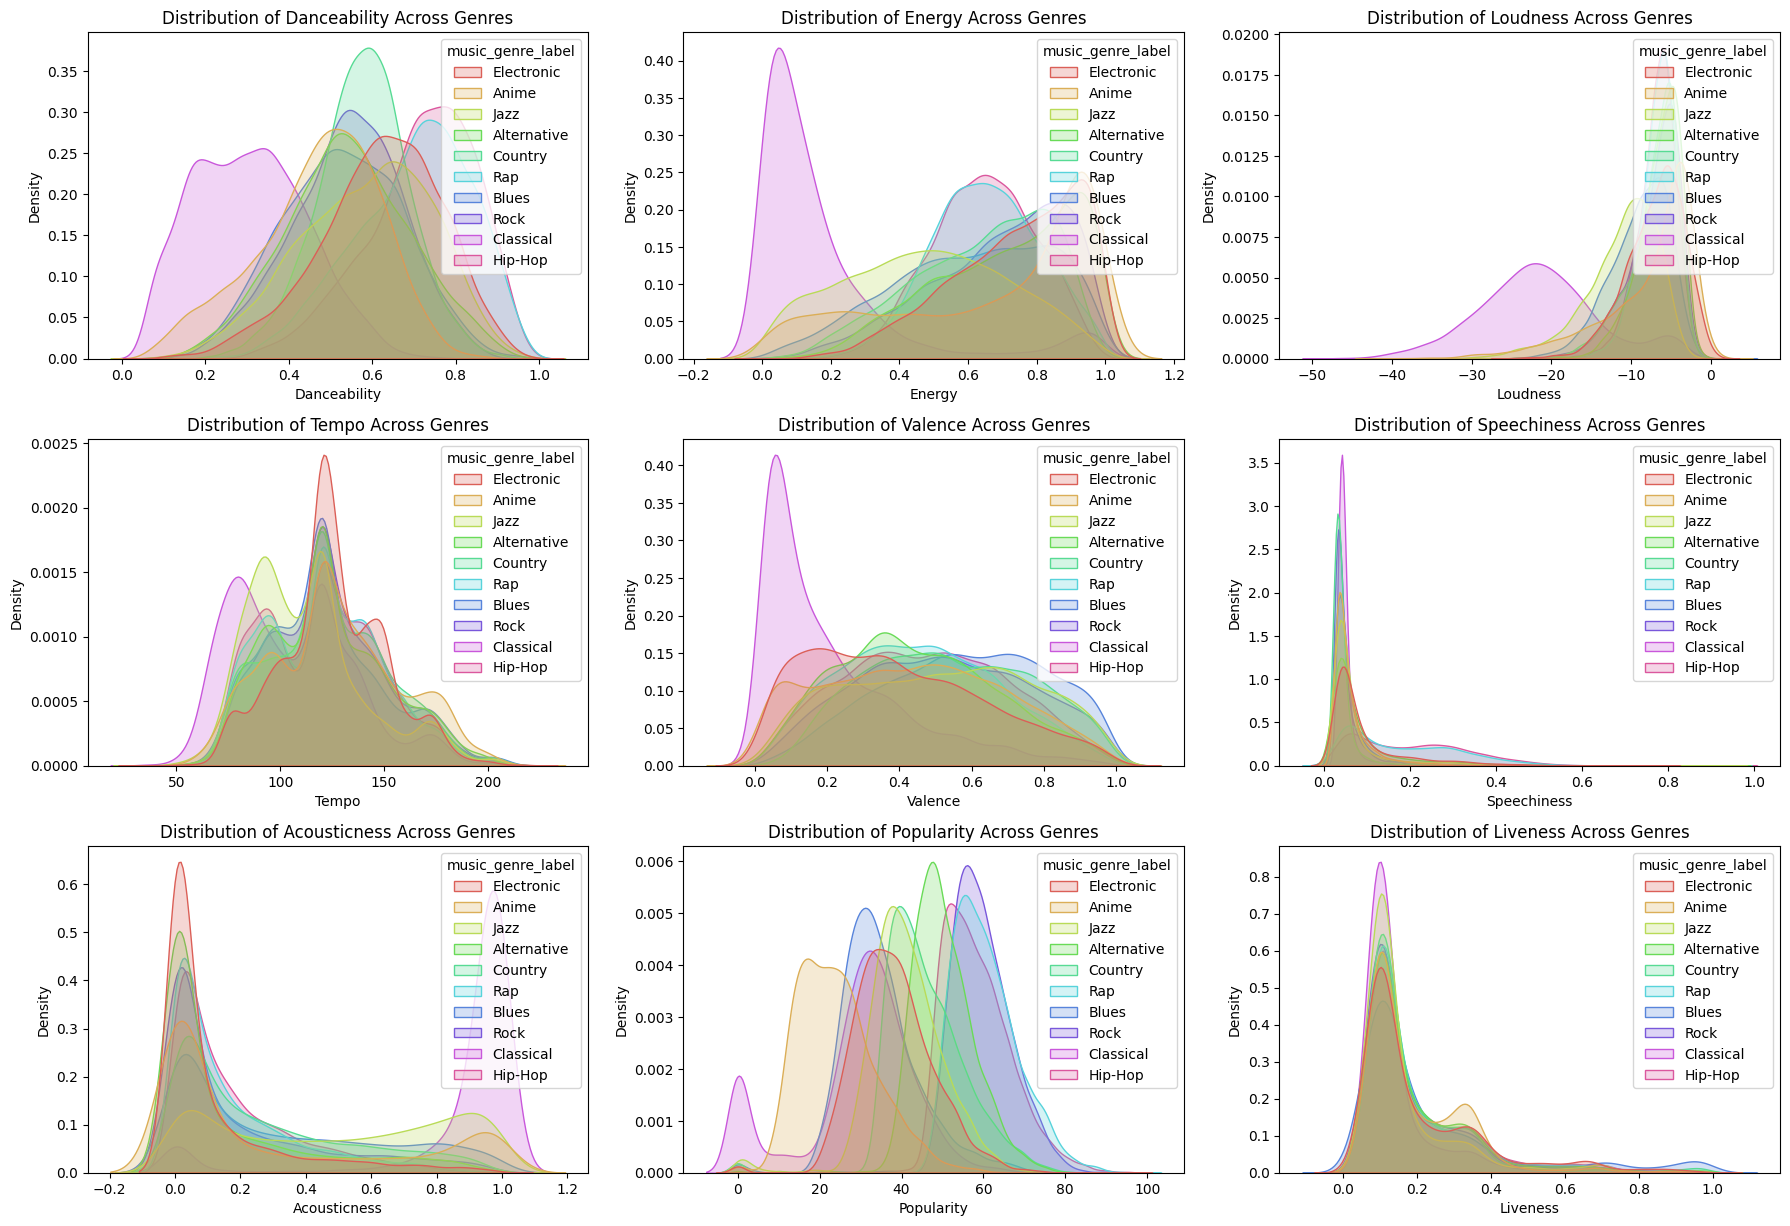

In [ ]:
# recover original labels for music_genre for visualization
music_data['music_genre_label'] = label_encoder.inverse_transform(music_data['music_genre'])

unique_genres = music_data['music_genre_label'].unique()
palette = sns.color_palette("hls", 10)
genre_colors = dict(zip(unique_genres, palette))
colors = [genre_colors[label] for label in music_data['music_genre_label']]

features = ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'speechiness', 'acousticness','popularity', 'liveness', ]
plt.figure(figsize=(18, 16))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.kdeplot(data=music_data, x=feature, hue="music_genre_label", fill=True, palette=genre_colors)
    plt.title(f'Distribution of {feature.capitalize()} Across Genres')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

Visualization source: https://medium.com/@navodas88/music-genre-prediction-using-audio-features-96dea4e71ad3

# Standardizing numerical features

In [ ]:
numerical_cols = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness','speechiness','tempo','valence']
scaler = StandardScaler()
scaled = scaler.fit_transform(music_data[numerical_cols])
music_data[numerical_cols] = scaled
music_data.head(10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,music_genre_label
0,-1.108003,-0.883886,0.524878,-0.154369,1.289876,1.875809,-0.488113,0.638132,1,-0.185322,...,0,0,0,0,0,0,0,0,0,Electronic
1,-0.850633,-0.860390,0.356933,-0.239968,1.097101,2.361357,-0.432433,0.339248,1,-0.627258,...,0,0,1,0,0,0,0,0,0,Electronic
2,-1.043661,-0.888632,0.345737,-0.265269,0.586813,-0.521812,2.104140,0.732892,0,-0.582867,...,0,0,0,0,0,0,0,0,1,Electronic
3,-0.657606,-0.823184,1.207853,-0.725393,0.378918,-0.550300,-0.228269,0.752201,0,1.434452,...,0,1,0,0,0,0,0,0,0,Electronic
4,-0.786291,-0.883974,0.446504,-0.201488,-0.048212,2.235361,-0.228269,0.465324,0,-0.515787,...,0,0,0,0,0,0,1,0,0,Electronic
5,0.178845,-0.882275,1.101488,2.603351,0.496095,2.066341,0.136749,-0.224445,1,-0.516774,...,0,0,1,0,0,0,0,0,0,Electronic
6,0.114502,-0.812930,0.077025,-0.276645,0.768248,-0.558051,-0.543794,0.785302,0,2.539292,...,0,0,0,0,0,0,0,0,0,Electronic
7,-0.078525,-0.810586,1.403789,1.627781,0.401597,2.216922,-0.806732,-0.033302,1,-0.445748,...,0,0,0,0,0,0,0,1,0,Electronic
8,-0.335894,-0.888837,-0.275659,0.463434,1.214278,-0.557226,-0.098347,0.966872,1,1.720527,...,0,0,0,0,0,1,0,0,0,Electronic
9,-1.429715,-0.870234,0.110614,-0.367352,0.496095,-0.523656,-0.512861,0.331460,1,0.783386,...,0,0,0,0,0,0,0,0,0,Electronic


# Train/test split

In [ ]:
test_indices = []
for genre in music_data['music_genre'].unique():
    genre_indices = music_data[music_data['music_genre'] == genre].index
    test_indices.extend(np.random.choice(genre_indices, 500, replace=False))

X_train = music_data.drop(index=test_indices)
X_test = music_data.loc[test_indices]

y_train = X_train['music_genre']
y_test = X_test['music_genre']
drop_cols = ['music_genre', 'music_genre_label']
X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (45000, 24)
X_test shape: (5000, 24)
y_train shape: (45000,)
y_test shape: (5000,)


# Dimensionality reduction with TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_train)

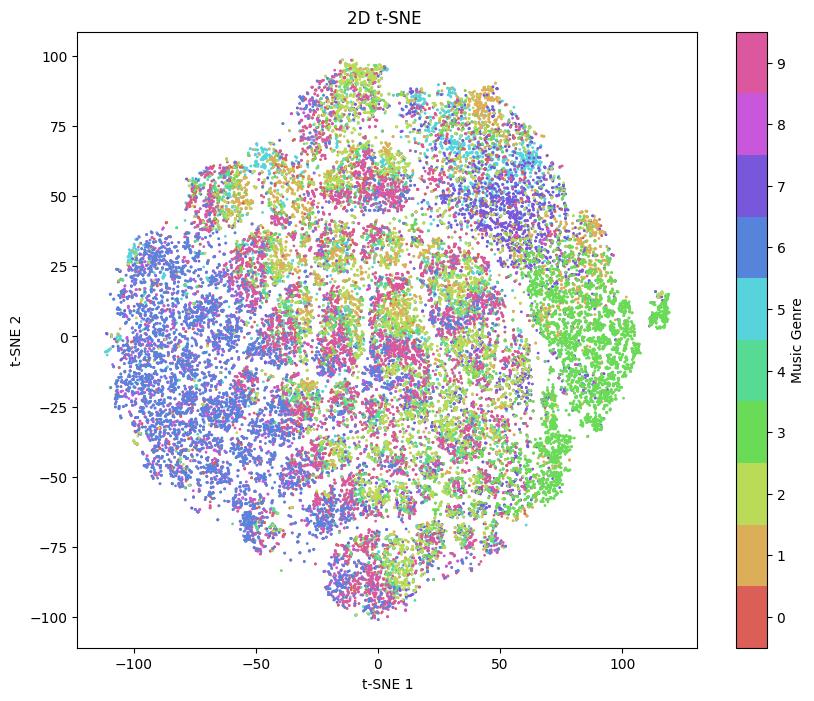

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors), alpha=1, s=1)
plt.colorbar(scatter, label='Music Genre', ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('2D t-SNE ')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
!pip install opentsne

# Dimesnionality reduction with UMAP

In [ ]:
!pip install umap-learn

In [ ]:
from umap import UMAP
reducer = UMAP(n_neighbors=30, n_components=2)
umap_results = reducer.fit_transform(X_train)
X_umap = reducer.transform(X_train)
X_train_umap = reducer.fit_transform(X_train)
X_test_umap = reducer.transform(X_test)

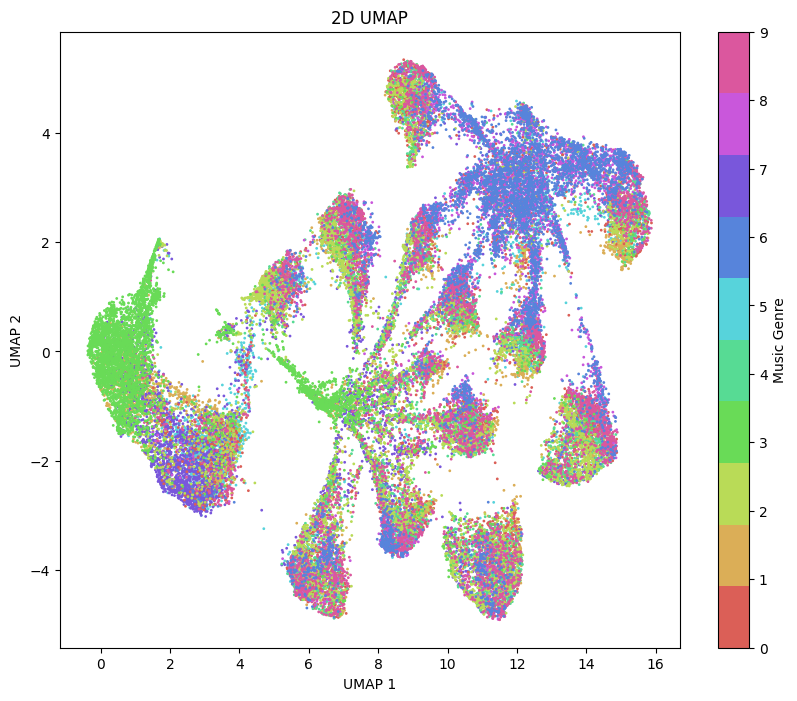

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors), alpha=1, label=i,s=1)
plt.colorbar(label='Music Genre')
plt.title('2D UMAP',)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Clustering with HDBSCAN

In [ ]:
!pip install hdbscan
import hdbscan

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1500, min_samples=10, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_umap)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


<ipython-input-29-d444d67aaceb>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clustered_points[:, 0], clustered_points[:, 1],


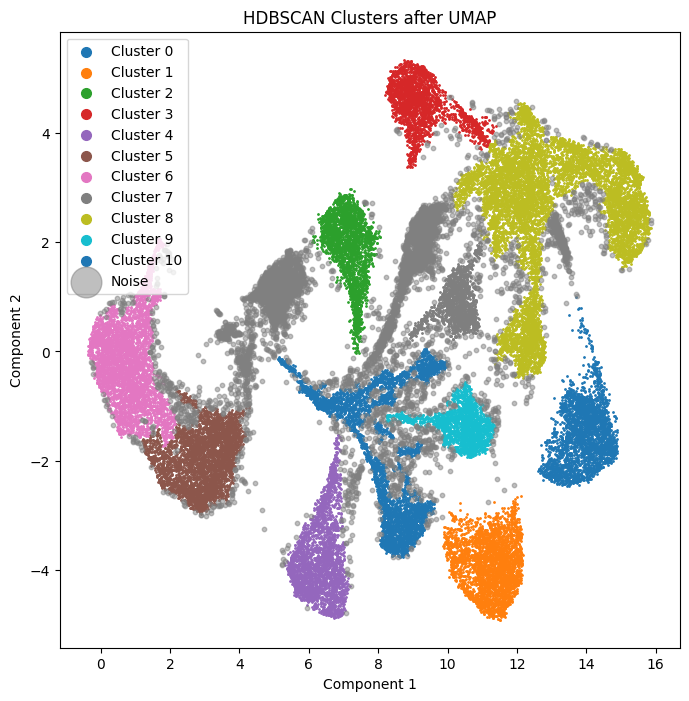

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#FFB30F', '#bcbd22', '#17becf']
unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 8))
for label in unique_labels:
    if label == -1:
        plt.scatter(X_umap[cluster_labels == label, 0],
                    X_umap[cluster_labels == label, 1],
                    color='gray', s=10, alpha=0.5, label='Noise')
    else:
        clustered_points = X_umap[cluster_labels == label]
        plt.scatter(clustered_points[:, 0], clustered_points[:, 1],
                    cmap=matplotlib.colors.ListedColormap(colors), s=1, label=f'Cluster {label}')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(fontsize=10, markerscale=7)
plt.grid(False)
plt.title("HDBSCAN Clusters after UMAP")
plt.show()

# Feature Engineering: Adding resulted cluster labels as features to training and test sets

In [ ]:
cluster_labels_train = clusterer.fit_predict(X_train_umap)

# predict cluster labels for the test set
cluster_labels_test, _ = hdbscan.approximate_predict(clusterer, X_test_umap)

# add cluster labels as features
X_train['cluster_label'] = cluster_labels_train
X_test['cluster_label'] = cluster_labels_test

# handle noise
noise_label = max(cluster_labels_train.max(), cluster_labels_test.max()) + 1
X_train['cluster_label'] = X_train['cluster_label'].replace(-1, noise_label)
X_test['cluster_label'] = X_test['cluster_label'].replace(-1, noise_label)

# XGBoost Classification

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'alpha': 0.01,
    'lambda': 1.0,
    'num_class': len(y_train.unique())
}
num_round = 100
bst = xgb.train(params, dtrain, num_round)

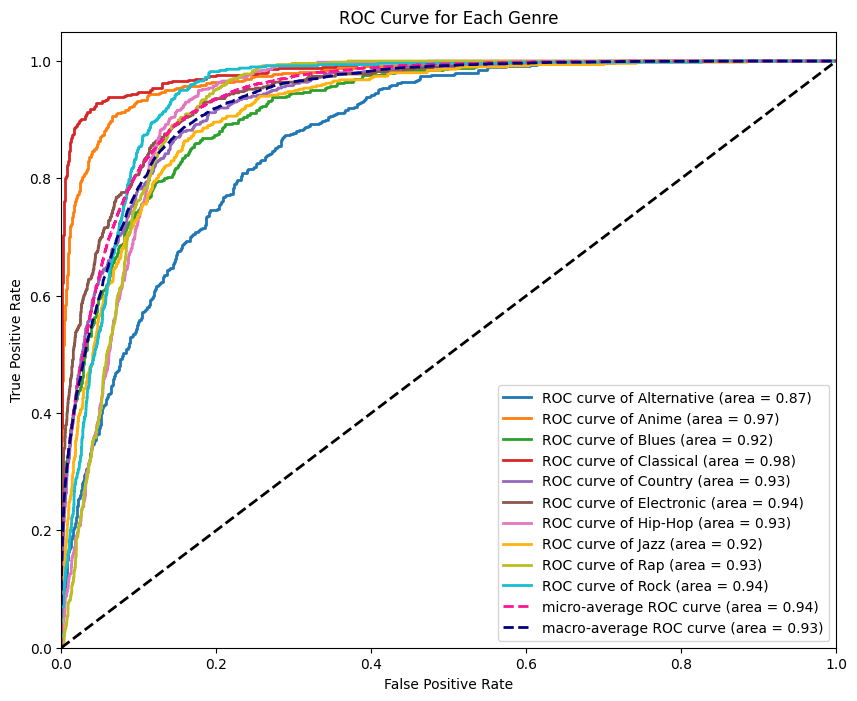

In [ ]:
original_labels = label_encoder.inverse_transform(y_test)

# predict probabilities on the test set
y_pred_prob = bst.predict(dtest)
y_test_bin = label_binarize(y_test, classes=range(10))


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

genre_names = label_encoder.inverse_transform(np.arange(10))

# plot the ROC curves for each genre
plt.figure(figsize=(10, 8))

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {genre_names[i]} (area = {roc_auc[i]:0.2f})')

# micro and macro average ROC curves
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='deeppink', lw=2,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='navy', lw=2,
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Genre')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_train_pred_prob = bst.predict(dtrain)
y_test_pred_prob = bst.predict(dtest)

train_accuracy = accuracy_score(y_train, np.argmax(y_train_pred_prob, axis=1))
test_accuracy = accuracy_score(y_test, np.argmax(y_test_pred_prob, axis=1))

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_train_bin = label_binarize(y_train, classes=range(10))
y_test_bin = label_binarize(y_test, classes=range(10))
train_roc_auc = roc_auc_score(y_train_bin, y_train_pred_prob, multi_class='ovr')
test_roc_auc = roc_auc_score(y_test_bin, y_test_pred_prob, multi_class='ovr')

print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}\n")

print("Classification Report (Train):")
print(classification_report(y_train, np.argmax(y_train_pred_prob, axis=1)))

print("Classification Report (Test):")
print(classification_report(y_test, np.argmax(y_test_pred_prob, axis=1)))

Train Accuracy: 0.6461
Test Accuracy: 0.5906
Train ROC AUC: 0.9495
Test ROC AUC: 0.9341

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.54      0.41      0.47      4500
           1       0.84      0.78      0.81      4500
           2       0.69      0.60      0.64      4500
           3       0.87      0.86      0.87      4500
           4       0.63      0.64      0.63      4500
           5       0.72      0.68      0.70      4500
           6       0.53      0.57      0.55      4500
           7       0.62      0.61      0.61      4500
           8       0.54      0.53      0.53      4500
           9       0.54      0.78      0.64      4500

    accuracy                           0.65     45000
   macro avg       0.65      0.65      0.65     45000
weighted avg       0.65      0.65      0.65     45000

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.44      0.38   